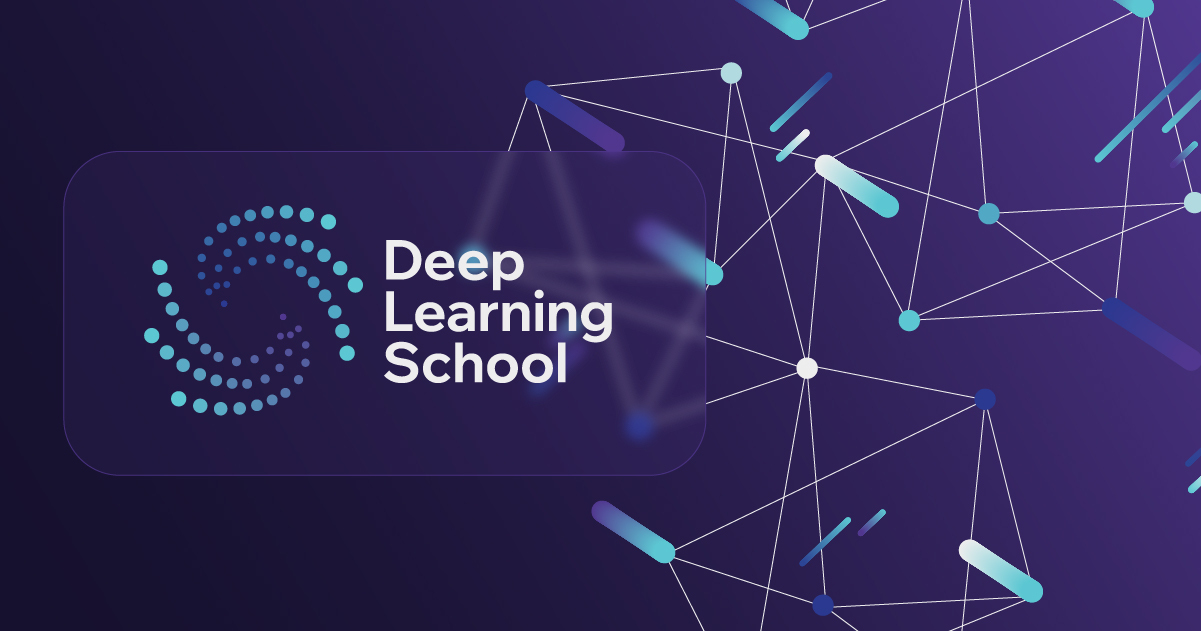

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Детекция объектов</b></h3>

В этом домашнем задании мы продолжим работу над детектором из семинара, поэтому при необходимости можете заимствовать оттуда любой код.

Домашнее задание можно разделить на следующие части:

* Переделываем модель [5]
  * backbone[1],
  * Neck [3],
  * Head [1]
* Label assignment [2]:
  * TAL [2]
* Лоссы [1]:
  * CIoU loss [1]
* Кто больше? [5]
  * 0.15 mAP [1]
  * 0.3 mAP  [2]
  * 0.6 mAP [5]

**Максимальный балл:** 10 баллов. (+3 балла бонус).

In [37]:
# !pip install torchmetrics

In [38]:
import torch
import timm
import torch.nn as nn
import numpy as np
import pandas as pd
import albumentations as A

from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset
from albumentations.pytorch.transforms import ToTensorV2

import math
from functools import partial
from collections import Counter, defaultdict

import io
import cv2
import matplotlib.pyplot as plt

import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm.auto import tqdm
from torchvision.ops import nms, box_iou
from torchvision.models.detection.anchor_utils import AnchorGenerator

from torchmetrics.detection import MeanAveragePrecision
from torchvision.ops import box_convert

### Загрузка данных

Мы продолжаем работу с датасетом из семинара - Halo infinite ([сслыка](https://universe.roboflow.com/graham-doerksen/halo-infinite-angel-aim)). Загрузка данных и создание датасета полностью скопированы из семинара.

Сначала загружаем данные

In [39]:
splits = {'train': 'data/train-00000-of-00001-0d6632d599c29801.parquet',
          'validation': 'data/validation-00000-of-00001-c6b77a557eeedd52.parquet',
          'test': 'data/test-00000-of-00001-866d29d8989ea915.parquet'}
df_train = pd.read_parquet("hf://datasets/Francesco/halo-infinite-angel-videogame/" + splits["train"])
df_val = pd.read_parquet("hf://datasets/Francesco/halo-infinite-angel-videogame/" + splits["validation"])
df_test = pd.read_parquet("hf://datasets/Francesco/halo-infinite-angel-videogame/" + splits["test"])

Создаем датасет для предобработки данных

In [40]:
class HaloDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        df_objects = pd.json_normalize(dataframe['objects'])[["bbox", "category"]]
        df_images = pd.json_normalize(dataframe['image'])[["bytes"]]
        self.data = dataframe[["image_id"]].join(df_objects).join(df_images)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        """Загружаем данные и разметку для объекта с индексом `idx`.

        labels: List[int] Набор классов для каждого ббокса,
        boxes: List[List[int]] Набор ббоксов в формате (x_min, y_min, w, h).
        """
        row = self.data.iloc[idx]
        image = Image.open(io.BytesIO(row["bytes"]))
        image = np.array(image)

        target = {}
        target["image_id"] = row["image_id"]

        labels = [row["category"]] if isinstance(row["category"], int) else row['category']
        labels = [label - 1 for label in labels]
        boxes = row['bbox'].tolist()

        if self.transform is not None:
            transformed = self.transform(image=image, bboxes=boxes, labels=labels)
            image, boxes, labels = transformed["image"], transformed["bboxes"], transformed["labels"]
        else:
            image = transforms.ToTensor()(image)

        boxes_xyxy = []
        final_valid_labels = []
        if boxes:
            for i, box_coco in enumerate(boxes):
                 if len(box_coco) == 4:
                     x_min, y_min, w, h = box_coco
                     if w > 0 and h > 0:
                         boxes_xyxy.append([x_min, y_min, x_min + w, y_min + h])
                         if i < len(labels):
                             final_valid_labels.append(labels[i])

        if boxes_xyxy:
            target['boxes'] = torch.tensor(boxes_xyxy, dtype=torch.float32)
            target['labels'] = torch.tensor(final_valid_labels, dtype=torch.int64)
        else:
            target['boxes'] = torch.empty((0, 4), dtype=torch.float32)
            target['labels'] = torch.empty((0,), dtype=torch.int64)

        if not isinstance(image, torch.Tensor):
             image = transforms.ToTensor()(image)
        return image, target


# Исходный collate_fn
def collate_fn(batch):
    images, targets = tuple(zip(*batch))
    images = torch.stack(images)
    return images, list(targets)

Тут можно написать любые аугментации

In [41]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
IMAGE_SIZE = 640 # Используем ту же переменную

train_transform = A.Compose(
    [
        A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format='coco', label_fields=['labels'], min_visibility=0.1)
)

test_transform = A.Compose(
    [
        A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE),
        A.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
     bbox_params=A.BboxParams(format='coco', label_fields=['labels'])
)

Не забываем инициализировать наш датасет

In [42]:
class_to_color = {
    1: (89, 161, 197),
    2: (204, 79, 135),
    3: (125, 216, 93),
    4: (175, 203, 33),
}

class_to_name = {
    1 : "enemy",
    2 : "enemy-head",
    3 : "friendly",
    4 : "friendly-head"
}

train_dataset = HaloDataset(df_train, transform=train_transform)
test_dataset = HaloDataset(df_test, transform=test_transform)
val_dataset = HaloDataset(df_val, transform=test_transform)

In [43]:
val_dataset.data.category

0     [2, 1]
1     [2, 1]
2     [2, 1]
3     [2, 1]
4     [2, 1]
       ...  
66    [2, 1]
67    [2, 1]
68       [1]
69    [2, 1]
70    [4, 3]
Name: category, Length: 71, dtype: object

## Переделываем модель [5 баллов]

В семинаре мы реализовали самый базовый детектор, а сейчас настало время его улучшать.

### Backbone [1 балл]

В лекции мы заморозили все слои у модели. Вам нужно написать бекбоун с возможностью разморозки __k__ последних слоев или блоков (на ваш выбор).

In [44]:
import timm

In [45]:
class Backbone(nn.Module):
    def __init__(self, model_name="efficientnet_b0", unfreeze_last=3, out_indices=(-1, -2, -3)):
        super().__init__()
        self.backbone = timm.create_model(model_name, pretrained=True, features_only=True, out_indices=out_indices)
        for param in self.backbone.parameters():
            param.requires_grad = False

        all_params = list(self.backbone.parameters())
        parameters_to_unfreeze = all_params[-unfreeze_last:]
        unfrozen_param_indices = list(range(len(all_params) - len(parameters_to_unfreeze), len(all_params)))

        if unfreeze_last > 0:
            all_params = list(self.backbone.parameters())
            num_to_unfreeze = min(unfreeze_last, len(all_params))
            for param in all_params[-num_to_unfreeze:]:
                param.requires_grad = True

    def forward(self, x):
        return self.backbone(x)

### NECK [3 балла]

Вам предлагается на выбор написать одну из двух шей:

#### Feature Pyramid Network [2 балла]

Знакомая из лекции архитектура шеи:

<center><img src="https://user-images.githubusercontent.com/57972646/69858594-b14a6c00-12d5-11ea-8c3e-3c17063110d3.png"/></center>


* [Feature Pyramid Networks for Object Detection](https://arxiv.org/abs/1612.03144)

Она состоит из top-down пути, в котором происходит 2 вещи:
1. Увеличивается пространственная размерность фичей,
2. С помощью скипконнекшеннов, добавляются фичи из backbone модели.

Для увеличения пространственной размерности используется __nearest neighbor upsampling__, а фичи из шеи и бекбоуна суммируются.

#### Path Aggregation Network [3 балла]

Другая архитектура немного сложнее. Она содержит не только top-down путь, но ещё bottom-up путь:

<center><img src="https://i.ibb.co/k68BWBGv/path-aggregation-network.png" width="500"/></center>

* [Path Aggregation Network for Instance Segmentation](https://arxiv.org/abs/1803.01534)

Подробное описание архитектуры можно найти в секции 3 (Framework). Реализовывать adaptive feature pooling не нужно.


__TIPS__:
* Можете использовать базовые классы из лекции,
* Воспользуйтесь AnchorGenerator-ом, чтобы создавать якоря сразу для нескольких выходов,
* Не забудьте использовать nn.ModuleList, если захотите сделать динамическое количество голов у модели,
* Также, можно добавить доп конволюцию (3х3 с паддингом) у каждого выхода шеи.

In [46]:
class ConvBNAct(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=1, stride=1, padding=None, groups=1):
        super().__init__()
        if padding is None:
            padding = (kernel_size - 1) // 2 * 1

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, groups=groups, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.activation_layer = nn.SiLU()

    def forward(self, x):
        return self.activation_layer(self.bn(self.conv(x)))

# --- CSP-подобный блок для шеи ---
class CSPBlockNeck(nn.Module):
    def __init__(self, in_channels, out_channels, num_bottleneck_layers=1, expansion=0.5):
        super().__init__()
        hidden_channels = int(out_channels * expansion)
        self.conv1 = ConvBNAct(in_channels, hidden_channels, kernel_size=1)
        self.conv2 = ConvBNAct(in_channels, hidden_channels, kernel_size=1)
        self.bottlenecks = nn.Sequential(
            *(ConvBNAct(hidden_channels, hidden_channels, kernel_size=3) for _ in range(num_bottleneck_layers))
        )
        self.conv_final = ConvBNAct(2 * hidden_channels, out_channels, kernel_size=1)

    def forward(self, x):
        x1 = self.conv1(x)
        x1 = self.bottlenecks(x1)
        x2 = self.conv2(x)
        out = self.conv_final(torch.cat((x1, x2), dim=1))
        return out

class PANNeck(nn.Module):
    def __init__(self, backbone_output_channels, neck_output_channels=256, num_csp_blocks=1):
        super().__init__()

        ch_c3, ch_c4, ch_c5 = backbone_output_channels[-3:] # Берем последние три

        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

        # Top-down pathway
        self.conv_p5 = ConvBNAct(ch_c5, neck_output_channels, kernel_size=1)
        self.csp_p4 = CSPBlockNeck(ch_c4 + neck_output_channels, neck_output_channels, num_csp_blocks)
        self.csp_p3 = CSPBlockNeck(ch_c3 + neck_output_channels, neck_output_channels, num_csp_blocks) # N3

        # Bottom-up pathway
        self.downsample_n4 = ConvBNAct(neck_output_channels, neck_output_channels, kernel_size=3, stride=2)
        self.csp_n4 = CSPBlockNeck(neck_output_channels * 2, neck_output_channels, num_csp_blocks) # N4
        self.downsample_n5 = ConvBNAct(neck_output_channels, neck_output_channels, kernel_size=3, stride=2)
        self.csp_n5 = CSPBlockNeck(neck_output_channels * 2, neck_output_channels, num_csp_blocks) # N5


    def forward(self, backbone_features):
        feat_c3, feat_c4, feat_c5 = backbone_features[-3:]

        # Top-down
        p5_inter = self.conv_p5(feat_c5)
        p5_up = self.upsample(p5_inter)
        p4_inter = self.csp_p4(torch.cat([feat_c4, p5_up], 1))
        p4_up = self.upsample(p4_inter)
        n3_out = self.csp_p3(torch.cat([feat_c3, p4_up], 1))

        # Bottom-up
        n3_down = self.downsample_n4(n3_out)
        n4_out = self.csp_n4(torch.cat([n3_down, p4_inter], 1))
        n4_down = self.downsample_n5(n4_out)
        n5_out = self.csp_n5(torch.cat([n4_down, p5_inter], 1))

        return (n3_out, n4_out, n5_out)

### Head [1 балл]

В качестве шеи можно выбрать __один из двух__ вариантов:

#### 1. Decoupled Head

Реализовать Decoupled Head из [YOLOX](https://arxiv.org/abs/2107.08430).
<center><img src="https://i.ibb.co/BVtBR2R3/Decoupled-head.jpg"/></center>

**TIP**: Возьмите за основу голову из семинара, тк она сильно похожа на Decoupled Head.

Изменять количество параметров у шей на разных уровнях не обязательно.

#### 2. Confidence score free head

Нужно взять за основу голову из семинара и полностью убрать предсказание confidence score. Чтобы модель предсказывала только 2 группы: ббоксы и классы.

Есть следующие способы удаления confidence score:
* Добавление нового класса ФОН. Обычно его обозначают нулевым классом.
* Присваивание ббоксам БЕЗ объекта вектор из нулей в качестве таргета.

Выберете тот, который вам больше нравится и будте внимательны при расчете лосса!

**Важно!** Удаление confidence score повлияет на следующие методы из семинара:
* target_assign
* ComputeLoss
* _filter_predictions

In [47]:
class DecoupledHead(nn.Module):
    def __init__(self, num_classes, num_anchors_per_level, neck_channels=256, head_channels=256):
        super().__init__()
        self.num_anchors = num_anchors_per_level

        self.cls_convs = nn.Sequential(
            ConvBNAct(neck_channels, head_channels, kernel_size=3),
            ConvBNAct(head_channels, head_channels, kernel_size=3)
        )
        self.reg_convs = nn.Sequential(
            ConvBNAct(neck_channels, head_channels, kernel_size=3),
            ConvBNAct(head_channels, head_channels, kernel_size=3)
        )

        self.cls_predictor = nn.Conv2d(head_channels, num_anchors_per_level * num_classes, kernel_size=1)
        self.reg_predictor = nn.Conv2d(head_channels, num_anchors_per_level * 4, kernel_size=1) # bbox
        self.obj_predictor = nn.Conv2d(head_channels, num_anchors_per_level * 1, kernel_size=1) # objectness

        self._initialize_biases()

    def _initialize_biases(self, prior_prob=1e-2):
        bias_value = -math.log((1 - prior_prob) / prior_prob)
        nn.init.constant_(self.cls_predictor.bias, bias_value)
        nn.init.constant_(self.obj_predictor.bias, bias_value)

    def forward(self, neck_features):
        cls_outputs, reg_outputs, obj_outputs = [], [], []

        for feature_level in neck_features:
            cls_feat = self.cls_convs(feature_level)
            reg_feat = self.reg_convs(feature_level)

            cls_outputs.append(self.cls_predictor(cls_feat))
            reg_outputs.append(self.reg_predictor(reg_feat))
            obj_outputs.append(self.obj_predictor(reg_feat))

        return cls_outputs, reg_outputs, obj_outputs

Теперь можно снова реализовать класс детектора с учетом всех частей выше!

In [48]:
class Model(nn.Module):
    def __init__(self, backbone_name="efficientnet_b0", num_classes=4,
                 unfreeze_last=3, backbone_out_indices=(-3, -2, -1),
                 neck_output_channels=128,
                 head_channels=128,
                 anchor_sizes=((32,), (64,), (128,)),
                 aspect_ratios=((0.5, 1.0, 2.0),) * 3,
                 pretrained_backbone=True, **kwargs):
        super().__init__()
        self.num_classes = num_classes

        self.backbone = Backbone(
            model_name=backbone_name,
            unfreeze_last=unfreeze_last,
            out_indices=backbone_out_indices
        )
        backbone_output_channels = self.backbone.backbone.feature_info.channels()
        self.strides = self.backbone.backbone.feature_info.reduction()[-len(backbone_out_indices):]

        self.neck = PANNeck(
            backbone_output_channels=backbone_output_channels,
            neck_output_channels=neck_output_channels,
            num_csp_blocks=1
        )

        if isinstance(anchor_sizes[0], (int, float)): # Если только один размер на уровень
            num_anchors_per_level = len(aspect_ratios[0])
        elif isinstance(anchor_sizes[0], (list, tuple)): # Если несколько размеров на уровень
            num_anchors_per_level = len(anchor_sizes[0]) * len(aspect_ratios[0])
        self.num_anchors_per_level = num_anchors_per_level

        self.head = DecoupledHead(
            num_classes=num_classes,
            num_anchors_per_level=self.num_anchors_per_level,
            neck_channels=neck_output_channels,
            head_channels=head_channels
        )

        self.anchor_generator = AnchorGenerator(anchor_sizes, aspect_ratios)

    def forward(self, x):
        B, C, H, W = x.shape
        image_size = (H, W)
        features = self.backbone(x)
        neck_features = self.neck(features)

        strides_for_grid = [[s, s] for s in self.strides]
        grid_sizes = [feature_map.shape[-2:] for feature_map in neck_features]

        anchors_list_xyxy = self.anchor_generator.grid_anchors(grid_sizes, strides_for_grid)
        anchors_list_xyxy = [anchors.to(x.device) for anchors in anchors_list_xyxy]

        head_outputs = self.head(neck_features)

        return head_outputs, anchors_list_xyxy

## Label assignment [2]
В этой секции предлагается заменить функцию `assign_target` на более современный алгоритм который называется Task alignment learning.

Он описан в статье [TOOD](https://arxiv.org/abs/2108.07755) в секции 3.2. Для удобства вот его основные шаги:

1. Посчитать значение метрики для каждого предсказанного ббокса:
    
$$t = s^\alpha * u^\beta$$
    
где,
* $s$ — classification score, или вероятность принадлежности предсказанного ббокса к классу реального ббокса (**GT**);
* $u$ — IoU между предсказанным и реальным ббоксами;
* $\alpha,\ \beta$ — нормализационные константы, обычно $\alpha = 6.0, \ \beta = 1.0$.
    
2. Отфильтровать предсказания на основе **GT**.

    Для якорных детекторов, обычно, выбираются только те предсказания, центры якорей которых находятся внутри GT.
4. Для каждого **GT** выбрать несколько (обычно 5 или 13) самых подходящих предсказаний.
5. Если предсказание рассматривается в качестве подходящего для нескольких **GT** — выбрать **GT** с наибольшим пересечением по IoU.


**BAЖНО**: если будете использовать Runner из лекции, не забудьте поменять параметры  в `self.assign_target_method` в методе `_run_train_epoch`.

In [49]:
def tal_assigner(pred_cls_scores, pred_bboxes_xyxy, anchor_points_xy, gt_bboxes_xyxy, gt_labels, topk=13, alpha=6.0, beta=1.0):
    num_anchors = pred_bboxes_xyxy.shape[0]
    num_gt = gt_bboxes_xyxy.shape[0]
    device = pred_bboxes_xyxy.device
    num_classes = pred_cls_scores.shape[1]

    assigned_gt_inds = torch.full((num_anchors,), -1, dtype=torch.long, device=device)
    assigned_labels = torch.full((num_anchors,), num_classes, dtype=torch.long, device=device)
    assigned_bboxes = torch.zeros((num_anchors, 4), dtype=torch.float32, device=device)
    assigned_scores = torch.zeros((num_anchors, num_classes), dtype=torch.float32, device=device)

    if num_gt == 0:
        fg_mask = torch.zeros(num_anchors, dtype=torch.bool, device=device)
        return assigned_gt_inds, assigned_labels, assigned_bboxes, assigned_scores, fg_mask

    iou_matrix = box_iou(pred_bboxes_xyxy, gt_bboxes_xyxy)
    pred_cls_probs = pred_cls_scores.sigmoid()
    gt_labels_expanded = gt_labels.reshape(1, num_gt).expand(num_anchors, num_gt) 
    cls_scores_for_gt = torch.gather(pred_cls_probs, 1, gt_labels_expanded)
    alignment_metric = (cls_scores_for_gt.pow(alpha)) * (iou_matrix.pow(beta)) 
    
    anchor_cx = anchor_points_xy[:, 0].unsqueeze(1).expand(-1, num_gt)
    anchor_cy = anchor_points_xy[:, 1].unsqueeze(1).expand(-1, num_gt)
    gt_xmin = gt_bboxes_xyxy[:, 0].unsqueeze(0).expand(num_anchors, -1)
    gt_ymin = gt_bboxes_xyxy[:, 1].unsqueeze(0).expand(num_anchors, -1)
    gt_xmax = gt_bboxes_xyxy[:, 2].unsqueeze(0).expand(num_anchors, -1)
    gt_ymax = gt_bboxes_xyxy[:, 3].unsqueeze(0).expand(num_anchors, -1)

    #True если центр якоря i внутри GT j
    is_in_gt_mask = (anchor_cx >= gt_xmin) & (anchor_cx <= gt_xmax) & \
                    (anchor_cy >= gt_ymin) & (anchor_cy <= gt_ymax)

    candidate_metrics = torch.where(is_in_gt_mask, alignment_metric, torch.tensor(-1.0, device=device))

    max_metric_per_anchor = torch.full((num_anchors,), -1.0, dtype=torch.float32, device=device)

    for gt_idx in range(num_gt):
        current_gt_metrics = candidate_metrics[:, gt_idx]

        num_valid_candidates = (current_gt_metrics > -1).sum()
        current_topk = min(topk, num_valid_candidates.item())

        if current_topk > 0:
            topk_metrics, topk_indices = torch.topk(current_gt_metrics, k=current_topk)

            is_better_assignment = topk_metrics > max_metric_per_anchor[topk_indices]

            indices_to_update = topk_indices[is_better_assignment]
            assigned_gt_inds[indices_to_update] = gt_idx
            max_metric_per_anchor[indices_to_update] = topk_metrics[is_better_assignment]

    fg_mask = assigned_gt_inds >= 0

    assigned_labels[fg_mask] = gt_labels[assigned_gt_inds[fg_mask]]
    assigned_bboxes[fg_mask] = gt_bboxes_xyxy[assigned_gt_inds[fg_mask]]

    if fg_mask.any():
        assigned_iou = iou_matrix[fg_mask, assigned_gt_inds[fg_mask]]
        one_hot_labels = F.one_hot(assigned_labels[fg_mask], num_classes=num_classes)
        assigned_scores[fg_mask] = one_hot_labels * assigned_iou.unsqueeze(-1)

    return assigned_gt_inds, assigned_labels, assigned_bboxes, assigned_scores, fg_mask

### DIoU [1]

Вместо SmoothL1, который используется в семинаре, реализуем лосс, основанный на пересечении ббоксов. В качестве тренировки давайте напишем Distance Intersection over Union (DIoU).

<center><img src=https://wikidocs.net/images/page/163613/Free_Fig_5.png></center>

Для его реализации разобъем задачу на части:

**1. Реализуем IoU:**

Пусть даны координаты для предсказанного ($B^p$) и истинного ($B^g$) ббоксов в формате XYXY или VOC PASCAL (левый верхний и правый нижний углы):

$B^p=(x^p_1, y^p_1, x^p_2, y^p_2)$, $B^g=(x^g_1, y^g_1, x^g_2, y^g_2)$, тогда алгоритм расчета будет следующий:

    1. Найдем площади обоих ббоксов:
$$ A^p = (x^p_2 - x^p_1) * (y^p_2 - y^p_1) $$
$$ A^g = (x^g_2 - x^g_1) * (y^g_2 - y^g_1) $$

    2. Посчитаем пересечение между ббоксами:

Тут мы предлагаем вам подумать как в общем виде можно расчитать размеры ббокса, который будет являться пересечением $B^p$ и $B^g$, а затем посчитать его площадь:

$$x^I_1 = \qquad \qquad y^I_1 = $$
$$x^I_2 = \qquad \qquad y^I_2 = $$

В общем виде, площать будет записываться следующим образом:

Если $x^I_2 > x^I_1$ & $y^I_2 > y^I_1$, тогда:

$$I = (x^I_2 - x^I_1) * (y^I_2 - y^I_1)$$

Иначе, $I = 0$.

    3. Считаем объединение ббоксов.

Мы можем посчитать эту площадь как сумму площадей двух ббоксов минус площадь пересечения (тк мы считаем её два раз в сумме площадей):

$$U = A^p + A^g - I$$

    4. Вычисляем IoU.

$$IoU = \frac{I}{U}$$

**2. Рассчитаем площадь выпуклой оболочки:**

Для расчета площади, сначала выпишите координаты верхнего левого и правого нижнего углов. Подумайте, чему будут равны эти координаты в общем случае?

$$x^С_1 = \qquad \qquad y^С_1 = $$
$$x^С_2 = \qquad \qquad y^С_2 = $$

Подсказка: Нарисуйте несколько вариантов пересечений предсказания и GT на бумажке, и выпишите координаты для выпуклой оболочки.

$$C = (x^C_2 - x^C_1) * (y^C_2 - y^C_1)$$

**3. Рассчитаем расстояние между цетрами ббоксов:**

Сначала находим координаты центров каждого из ббоксов (если ббоксы в формате YOLO, то и считать ничего не нужно), затем считаем Евклидово расстояние между центрами.

$d = $

Собираем все части вместе и считаем лосс по формуле:

$$ DIoU = 1 - IoU + \frac{d^2}{C^2}$$

Помните, что пар ббоксов может быть много! Возвращайте усредненное значение лосса.

In [50]:
from torchvision.ops import distance_box_iou_loss

In [51]:
def gen_bbox(num_boxes=10):
    min_corner = torch.randint(0, 100, (num_boxes, 2))
    max_corner = torch.randint(50, 150, (num_boxes, 2))

    for i in range(2):
        wrong_order = min_corner[:, i] > max_corner[:, i]
        if wrong_order.any():
            min_corner[wrong_order, i], max_corner[wrong_order, i] = max_corner[wrong_order, i], min_corner[wrong_order, i]
    return torch.cat((min_corner, max_corner), dim=1)

In [52]:
pred_boxes = gen_bbox(num_boxes=100)
true_boxes = gen_bbox(num_boxes=100)

In [53]:
print(f" DIoU: {distance_box_iou_loss(pred_boxes, true_boxes, reduction='mean').item()}")

 DIoU: 1.032204270362854


In [54]:
def calc_diou(pred_bb, gt_bb):
    pred_area = (pred_bb[2] - pred_bb[0]) * (pred_bb[3] - pred_bb[1])
    gt_area = (gt_bb[2] - gt_bb[0]) * (gt_bb[3] - gt_bb[1])

    inter_coord = [max(pred_bb[0], gt_bb[0]), max(pred_bb[1], gt_bb[1]), min(pred_bb[2], gt_bb[2]), min(pred_bb[3], gt_bb[3])]
    inter_area = max((inter_coord[2] - inter_coord[0]) * (inter_coord[3] - inter_coord[1]), 0)

    union_area = pred_area + gt_area - inter_area + 1e-8
    iou = inter_area / union_area

    outer_coord = [min(pred_bb[0], gt_bb[0]), min(pred_bb[1], gt_bb[1]), max(pred_bb[2], gt_bb[2]), max(pred_bb[3], gt_bb[3])]
    outer_dist = (outer_coord[2] - outer_coord[0]) ** 2 + (outer_coord[3] - outer_coord[1]) ** 2 + 1e-8

    pred_bb_center = [(pred_bb[2] + pred_bb[0]) / 2, (pred_bb[1] + pred_bb[3]) / 2]
    gt_bb_center = [(gt_bb[2] + gt_bb[0]) / 2, (gt_bb[1] + gt_bb[3]) / 2]

    centers_dist = (pred_bb_center[0] - gt_bb_center[0]) ** 2 + (pred_bb_center[1] - gt_bb_center[1]) ** 2

    return 1 - iou + centers_dist / outer_dist


def diou_loss(pred_boxes, gt_boxes):
    sum_diou = 0.0
    for pred_bb, gt_bb in zip(pred_boxes, gt_boxes):
        sum_diou += calc_diou(pred_bb, gt_bb)
    return (sum_diou / len(pred_boxes)).item()

In [56]:
pred_boxes = gen_bbox(num_boxes=1000)
true_boxes = gen_bbox(num_boxes=1000)

# проверим что написанный лосс выдает те же результаты что и лосс из торча.
assert np.isclose(diou_loss(pred_boxes, true_boxes), distance_box_iou_loss(pred_boxes, true_boxes, reduction="mean"), atol=1e-2)

## Кто больше? [5 баллов]

Наконец то мы дошли до самый интересной части. Тут мы раздаем очки за mAP'ы!

Все что вы написали выше вам поможет улучшить качество итогового детектора, настало время узнать насколько сильно :)

За достижения порога по mAP на тестовом наборе вы получаете баллы:
* 0.15 mAP [1]
* 0.3 mAP [2]
* 0.6 mAP [5]


**TIPS**:
1. На семинаре мы специально не унифицировали формат ббоксов между методами, чтобы обратить ваше внимание что за этим нужно следить. Чтобы было проще, сразу унифицируете формат по всему ноутбуку. Советуем использовать формат xyxy, тк IoU и NMS из torch используют именно этот формат. (Не забудьте поменять формат у таргета в `HaloDataset`).
2. Попробуйте перейти к IoU-based лоссу при обучении. То есть обучать не смещения, а сразу предсказывать ббокс.
3. Поэксперементируйте с подходами target assignment'а в процессе обучения. Например, можно на первых итерациях использовать обычный метод, а затем подключить TAL.
4. Добавьте аугментаций!

   Можно взять [albumentations](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/), библиотеку, которую мы использовали всеминаре. Или базовые аугментации из торча [тык](https://pytorch.org/vision/main/transforms.html). Если будете использовать торч, не забудте про ббоксы, transforms из коробки не будет их агументировать.
7. Попробуйте добавлять различные блоки из YOLO архитектур в шею вместо единичных конволюционных слоев. (Например, замените конволюции 3х3 на CSP блоки).
8. Попробуйте заменить NMS на другой метод (WeightedNMS, SoftNMS, etc.). Немного ссылок:
    * Статья про SoftNMS [тык](https://arxiv.org/pdf/1704.04503)
    * Статья про WeightedNMS [тык](https://openaccess.thecvf.com/content_ICCV_2017_workshops/papers/w14/Zhou_CAD_Scale_Invariant_ICCV_2017_paper.pdf)
    * Есть их реализация, правда на нумбе [git](https://github.com/ZFTurbo/Weighted-Boxes-Fusion?tab=readme-ov-file)
10. Не бойтесь эксперементировать и удачи!

Также, напишите развернутые ответы на следующие вопросы:

**Questions:**
1. Какой метод label assignment'a помогает лучше обучаться модели? Почему?
2. Какое из сделаных вами улучшений внесло наибольший вклад в качество модели? Как вы думаете, почему это произошло?
3. Какое из сделанных вами улучшений вообще не изменило метрику? Как вы думаете, почему это произошло?

Ниже определена вспомогательная функция для валидации качества. Можете использовать `Runner.validate`. Важное уточнение, ей нужен метод для фильтрации предсказаний. Можете тоже скопировать его из семинара, если он у вас не менялся.

In [57]:
def _filter_predictions(pred_bboxes_batch, pred_obj_scores_batch, pred_cls_scores_batch,
                           num_classes, score_threshold=0.1,
                           cls_score_threshold=0.1,
                           nms_threshold=0.5,
                           max_boxes_per_cls=10,
                           max_total_boxes=50,
                           return_type="list"):
    
    batch_size = len(pred_bboxes_batch)
    final_predictions = []

    for i in range(batch_size):
        pred_bboxes_xyxy_i = pred_bboxes_batch[i]
        pred_obj_scores_i = pred_obj_scores_batch[i].squeeze(-1)
        pred_cls_scores_i = pred_cls_scores_batch[i]
        current_device = pred_bboxes_xyxy_i.device

        # фильтрация по objectness score
        obj_keep_mask = pred_obj_scores_i > score_threshold
        if not obj_keep_mask.any():
             preds_img = {'boxes': torch.empty((0, 4), dtype=torch.float32, device=current_device),
                          'labels': torch.empty((0,), dtype=torch.long, device=current_device),
                          'scores': torch.empty((0,), dtype=torch.float32, device=current_device)}
             if return_type == "list":
                 preds_img = {k: v.cpu().tolist() for k, v in preds_img.items()}
             final_predictions.append(preds_img)
             continue

        bboxes_after_obj = pred_bboxes_xyxy_i[obj_keep_mask]
        cls_scores_after_obj = pred_cls_scores_i[obj_keep_mask]

        all_boxes_nms = []
        all_labels_nms = []
        all_scores_nms = []

        # NMS по классам
        for cls_idx in range(num_classes):
            cls_scores_current = cls_scores_after_obj[:, cls_idx]
            keep_indices_nms = nms(bboxes_after_obj, cls_scores_current, nms_threshold)

            if len(keep_indices_nms) > 0:
                bboxes_kept_nms = bboxes_after_obj[keep_indices_nms]
                scores_kept_nms = cls_scores_current[keep_indices_nms]
                labels_kept_nms = torch.full_like(scores_kept_nms, cls_idx, dtype=torch.long)

                if len(bboxes_kept_nms) > max_boxes_per_cls:
                    top_scores_idx = torch.argsort(scores_kept_nms, descending=True)[:max_boxes_per_cls]
                    bboxes_kept_nms = bboxes_kept_nms[top_scores_idx]
                    scores_kept_nms = scores_kept_nms[top_scores_idx]
                    labels_kept_nms = labels_kept_nms[top_scores_idx]

                all_boxes_nms.append(bboxes_kept_nms)
                all_labels_nms.append(labels_kept_nms)
                all_scores_nms.append(scores_kept_nms)

        # фильтрация по class score
        if len(all_boxes_nms) > 0:
            boxes_after_nms = torch.cat(all_boxes_nms, dim=0)
            labels_after_nms = torch.cat(all_labels_nms, dim=0)
            scores_after_nms = torch.cat(all_scores_nms, dim=0) 
            
            cls_keep_mask = scores_after_nms > cls_score_threshold 
            boxes_after_cls_thresh = boxes_after_nms[cls_keep_mask]
            labels_after_cls_thresh = labels_after_nms[cls_keep_mask]
            scores_after_cls_thresh = scores_after_nms[cls_keep_mask]

            if len(boxes_after_cls_thresh) > max_total_boxes:
                top_scores_idx = torch.argsort(scores_after_cls_thresh, descending=True)[:max_total_boxes]
                boxes_final = boxes_after_cls_thresh[top_scores_idx]
                labels_final = labels_after_cls_thresh[top_scores_idx]
                scores_final = scores_after_cls_thresh[top_scores_idx]
            else:
                boxes_final = boxes_after_cls_thresh
                labels_final = labels_after_cls_thresh
                scores_final = scores_after_cls_thresh

        else:
            boxes_final = torch.empty((0, 4), dtype=torch.float32, device=current_device)
            labels_final = torch.empty((0,), dtype=torch.long, device=current_device)
            scores_final = torch.empty((0,), dtype=torch.float32, device=current_device)

        preds_img = {'boxes': boxes_final, 'labels': labels_final, 'scores': scores_final} # scores - это скоры классов

        if return_type == "list":
             preds_img = {k: v.cpu().tolist() for k, v in preds_img.items()}
        elif return_type != "torch":
             raise ValueError(f"Invalid return_type: {return_type}")

        final_predictions.append(preds_img)

    return final_predictions

In [59]:
class ComputeLoss:
    def __init__(self, obj_loss=None, cls_loss=None,
                 weight_bbox=5, weight_obj=1.0, weight_cls=1.0,
                 num_classes=4):
        self.obj_loss_func = nn.BCEWithLogitsLoss(reduction='sum') if obj_loss is None else obj_loss
        self.cls_loss_func = nn.BCEWithLogitsLoss(reduction='sum') if cls_loss is None else cls_loss
        self.weight_bbox = weight_bbox
        self.weight_obj = weight_obj
        self.weight_cls = weight_cls
        self.num_classes = num_classes


    def __call__(self, predicts_per_image, targets_per_image):
        """
        predicts_per_image: Tuple (pred_reg_logits_i, pred_obj_logits_i, pred_cls_logits_i, pred_bboxes_xyxy_i)
        targets_per_image: Tuple (assigned_gt_inds, assigned_labels, assigned_bboxes_xyxy_target, assigned_scores, fg_mask)
        """
        pred_reg_logits, pred_obj_logits, pred_cls_logits, pred_bboxes_xyxy = predicts_per_image
        assigned_gt_inds, assigned_labels, assigned_bboxes_xyxy_target, assigned_scores, fg_mask = targets_per_image

        num_pos = fg_mask.sum().item()

        # Лосс локализации
        loss_bbox = torch.tensor(0.0, device=pred_reg_logits.device)
        if num_pos > 0:
            pos_pred_bboxes = pred_bboxes_xyxy[fg_mask]
            pos_target_bboxes = assigned_bboxes_xyxy_target[fg_mask]
            loss_bbox = distance_box_iou_loss(pos_pred_bboxes, pos_target_bboxes, reduction='sum')

        # Лосс классификации
        loss_cls = torch.tensor(0.0, device=pred_reg_logits.device)
        if num_pos > 0:
            loss_cls = self.cls_loss_func(pred_cls_logits[fg_mask], assigned_scores[fg_mask])

        # Лосс objectness
        target_obj_binary = torch.zeros_like(pred_obj_logits)
        target_obj_binary[fg_mask] = 1.0 # Позитивные = 1
        # Маска валидных = позитивные + негативные
        valid_obj_mask = torch.ones_like(pred_obj_logits, dtype=torch.bool)
        loss_obj = self.obj_loss_func(pred_obj_logits[valid_obj_mask], target_obj_binary[valid_obj_mask])


        # Итоговый лосс
        total_loss = (self.weight_cls * loss_cls +
                      self.weight_bbox * loss_bbox +
                      self.weight_obj * loss_obj) / max(num_pos, 1.0)

        # Убедимся, что возвращается скаляр
        if total_loss.ndim != 0:
            total_loss = total_loss.mean()

        return total_loss

In [70]:
class Runner:
    def __init__(self, model, compute_loss, optimizer, train_dataloader, assign_target_method, filter_predictions_func, device=None,
                 scheduler=None, assign_target_kwargs=None,
                 val_dataloader=None, val_every=5, cls_score_threshold=0.05, score_threshold=0.1, nms_threshold=0.5, max_boxes_per_cls=50,
                ):
        self.model = model
        self.compute_loss = compute_loss
        self.optimizer = optimizer
        self.train_dataloader = train_dataloader
        assign_target_kwargs = {} if assign_target_kwargs is None else assign_target_kwargs
        self.assign_target_method = partial(assign_target_method, **assign_target_kwargs)
        self.device = "cpu" if device is None else device
        self.scheduler = scheduler

        self.val_dataloader = val_dataloader if val_dataloader is not None else train_dataloader
        self.val_every = val_every
        self.score_threshold = score_threshold
        self.nms_threshold = nms_threshold
        self.max_boxes_per_cls = max_boxes_per_cls
        self.filter_predictions_func = filter_predictions_func

        self.batch_loss = []
        self.epoch_loss = []
        self.val_metric = []

    def _decode_predictions(self, reg_preds_levels, obj_preds_levels, cls_preds_levels, anchors_levels):
        
        all_pred_bboxes = []
        all_pred_obj_scores = []
        all_pred_cls_scores = []

        batch_size = reg_preds_levels[0].shape[0]
        num_anchors_per_loc = self.model.num_anchors_per_level 
        
        for i in range(batch_size):
            batch_bboxes = []
            batch_obj_scores = []
            batch_cls_scores = []
            current_device = reg_preds_levels[0].device

            for level_idx in range(len(reg_preds_levels)):
                reg_pred_lvl_i = reg_preds_levels[level_idx][i]
                obj_pred_lvl_i = obj_preds_levels[level_idx][i]
                cls_pred_lvl_i = cls_preds_levels[level_idx][i]
                anchors = anchors_levels[level_idx].to(current_device)

                H_feat, W_feat = reg_pred_lvl_i.shape[-2:]
                num_anchors_this_level = anchors.shape[0]

                cls_pred = cls_pred_lvl_i.permute(1, 2, 0).reshape(H_feat, W_feat, num_anchors_per_loc, self.model.num_classes).reshape(num_anchors_this_level, self.model.num_classes)
                reg_pred = reg_pred_lvl_i.permute(1, 2, 0).reshape(H_feat, W_feat, num_anchors_per_loc, 4).reshape(num_anchors_this_level, 4)
                obj_pred = obj_pred_lvl_i.permute(1, 2, 0).reshape(H_feat, W_feat, num_anchors_per_loc, 1).reshape(num_anchors_this_level, 1)

                # Декодируем ббоксы
                anchor_centers = (anchors[:, :2] + anchors[:, 2:]) / 2.0
                anchor_sizes = anchors[:, 2:] - anchors[:, :2]

                # Смещения центра
                dx = torch.sigmoid(reg_pred[:, 0])
                dy = torch.sigmoid(reg_pred[:, 1])
                pred_centers_x = anchor_centers[:, 0] + dx * anchor_sizes[:, 0]
                pred_centers_y = anchor_centers[:, 1] + dy * anchor_sizes[:, 1]

                # Размеры
                log_wh_max = 10.0
                log_wh_min = -10.0
                clamped_log_w = torch.clamp(reg_pred[:, 2], min=log_wh_min, max=log_wh_max)
                clamped_log_h = torch.clamp(reg_pred[:, 3], min=log_wh_min, max=log_wh_max)

                pred_w = torch.exp(clamped_log_w) * anchor_sizes[:, 0]
                pred_h = torch.exp(clamped_log_h) * anchor_sizes[:, 1]

                # Конвертируем в xyxy
                pred_xmin = pred_centers_x - pred_w / 2.0
                pred_ymin = pred_centers_y - pred_h / 2.0
                pred_xmax = pred_centers_x + pred_w / 2.0
                pred_ymax = pred_centers_y + pred_h / 2.0

                pred_xmax = torch.max(pred_xmax, pred_xmin + 1e-6)
                pred_ymax = torch.max(pred_ymax, pred_ymin + 1e-6)

                pred_bboxes_xyxy_level = torch.stack([pred_xmin, pred_ymin, pred_xmax, pred_ymax], dim=1)

                batch_bboxes.append(pred_bboxes_xyxy_level)
                batch_obj_scores.append(obj_pred.sigmoid())
                batch_cls_scores.append(cls_pred.sigmoid())

            all_pred_bboxes.append(torch.cat(batch_bboxes, dim=0))
            all_pred_obj_scores.append(torch.cat(batch_obj_scores, dim=0))
            all_pred_cls_scores.append(torch.cat(batch_cls_scores, dim=0))

        return all_pred_bboxes, all_pred_obj_scores, all_pred_cls_scores


    def _run_train_epoch(self, dataloader, verbose=True):
        self.model.train()
        batch_loss = []
        image_size_wh = (IMAGE_SIZE, IMAGE_SIZE)
        num_anchors_per_loc = self.model.num_anchors_per_level
        
        for images, targets in (pbar := tqdm(dataloader, desc=f"Process train epoch", leave=False)):
            images = images.to(self.device)
            (cls_preds_levels, reg_preds_levels, obj_preds_levels), anchors_levels_xyxy = self.model(images)

            all_anchors_xyxy_cat = torch.cat(anchors_levels_xyxy, dim=0).to(self.device)
            all_anchor_points_xy_cat = (all_anchors_xyxy_cat[:, :2] + all_anchors_xyxy_cat[:, 2:]) / 2.0

            batch_size = images.shape[0]
            num_classes = self.model.num_classes
            pred_cls_logits_batch = []
            pred_reg_logits_batch = []
            pred_obj_logits_batch = []
            pred_bboxes_xyxy_batch = []

            for level_idx in range(len(cls_preds_levels)):
                cls_pred_lvl = cls_preds_levels[level_idx]
                reg_pred_lvl = reg_preds_levels[level_idx]
                obj_pred_lvl = obj_preds_levels[level_idx]
                anchors_lvl = anchors_levels_xyxy[level_idx].to(self.device)
                anchor_centers_lvl = (anchors_lvl[:, :2] + anchors_lvl[:, 2:]) / 2.0 
                anchor_sizes_lvl = anchors_lvl[:, 2:] - anchors_lvl[:, :2]

                H_feat, W_feat = cls_pred_lvl.shape[-2:]
                num_anchors_this_level = anchors_lvl.shape[0]

                cls_pred = cls_pred_lvl.permute(0, 2, 3, 1).reshape(batch_size, H_feat, W_feat, num_anchors_per_loc, num_classes).reshape(batch_size, num_anchors_this_level, num_classes)
                reg_pred = reg_pred_lvl.permute(0, 2, 3, 1).reshape(batch_size, H_feat, W_feat, num_anchors_per_loc, 4).reshape(batch_size, num_anchors_this_level, 4)
                obj_pred = obj_pred_lvl.permute(0, 2, 3, 1).reshape(batch_size, H_feat, W_feat, num_anchors_per_loc, 1).reshape(batch_size, num_anchors_this_level, 1)

                anchor_centers_batch_lvl = anchor_centers_lvl.unsqueeze(0).repeat(batch_size, 1, 1)
                anchor_sizes_batch_lvl = anchor_sizes_lvl.unsqueeze(0).repeat(batch_size, 1, 1)

                dx = torch.sigmoid(reg_pred[..., 0])
                dy = torch.sigmoid(reg_pred[..., 1])
                pred_centers_x = anchor_centers_batch_lvl[..., 0] + dx * anchor_sizes_batch_lvl[..., 0]
                pred_centers_y = anchor_centers_batch_lvl[..., 1] + dy * anchor_sizes_batch_lvl[..., 1]
                pred_w = torch.exp(reg_pred[..., 2]) * anchor_sizes_batch_lvl[..., 0]
                pred_h = torch.exp(reg_pred[..., 3]) * anchor_sizes_batch_lvl[..., 1]

                pred_bboxes_xyxy_level = torch.stack([
                    pred_centers_x - pred_w / 2.0, pred_centers_y - pred_h / 2.0,
                    pred_centers_x + pred_w / 2.0, pred_centers_y + pred_h / 2.0
                ], dim=-1)

                pred_cls_logits_batch.append(cls_pred)
                pred_reg_logits_batch.append(reg_pred)
                pred_obj_logits_batch.append(obj_pred)
                pred_bboxes_xyxy_batch.append(pred_bboxes_xyxy_level)

            pred_cls_logits_cat = torch.cat(pred_cls_logits_batch, dim=1)
            pred_reg_logits_cat = torch.cat(pred_reg_logits_batch, dim=1)
            pred_obj_logits_cat = torch.cat(pred_obj_logits_batch, dim=1)
            pred_bboxes_xyxy_cat = torch.cat(pred_bboxes_xyxy_batch, dim=1)

            accum_loss = torch.tensor(0.0, device=self.device, requires_grad=False)
            for i in range(images.shape[0]):
                gt_bboxes_xyxy = targets[i]['boxes'].to(self.device)
                gt_labels = targets[i]['labels'].to(self.device)

                pred_cls_logits_i = pred_cls_logits_cat[i]
                pred_bboxes_xyxy_i = pred_bboxes_xyxy_cat[i]
                anchor_points_xy_i = all_anchor_points_xy_cat
                pred_reg_logits_i = pred_reg_logits_cat[i]
                pred_obj_logits_i = pred_obj_logits_cat[i].squeeze(-1)

                assigned_gt_inds, assigned_labels, assigned_bboxes_xyxy_target, assigned_scores, fg_mask = \
                    self.assign_target_method(
                        pred_cls_logits_i,
                        pred_bboxes_xyxy_i,
                        anchor_points_xy_i,
                        gt_bboxes_xyxy,
                        gt_labels
                    )

                predicts_i = (pred_reg_logits_i, pred_obj_logits_i, pred_cls_logits_i, pred_bboxes_xyxy_i)
                targets_i = (assigned_gt_inds, assigned_labels, assigned_bboxes_xyxy_target, assigned_scores, fg_mask)

                loss_i = self.compute_loss(predicts_i, targets_i)
                accum_loss = accum_loss + loss_i

            accum_loss_mean = accum_loss / images.shape[0]
            batch_loss.append(accum_loss_mean.item())

            self.optimizer.zero_grad()
            if accum_loss_mean.requires_grad:
                 accum_loss_mean.backward()
                 self.optimizer.step()

            if verbose:
                pbar.set_description(f"Current batch loss: {batch_loss[-1]:.4f}")

        return batch_loss


    def train(self, num_epochs=10, verbose=True):
        val_desc = ""
        best_val_score = 0
        for epoch in (epoch_pbar := tqdm(range(1, num_epochs+1), desc="Train epoch", total=num_epochs)):
            loss = self._run_train_epoch(self.train_dataloader, verbose=verbose)
            self.batch_loss.extend(loss)
            self.epoch_loss.append(np.mean(self.batch_loss[-len(self.train_dataloader):]))
            if self.val_dataloader is not None:
                val_metric_value = self.validate()
                self.val_metric.append(val_metric_value)
                val_desc = f" Val mAP: {val_metric_value:.6f}"
            if val_metric_value > best_val_score:
                torch.save(model.state_dict(), "./detector_sd")
                best_val_score = val_metric_value
                print(f"Epoch: {epoch} Train loss: {np.mean(self.batch_loss[-len(self.train_dataloader):]):.6f} Validation mAP: {val_metric_value:.6f} (saved)")
            else:
                print(f"Epoch: {epoch} Train loss: {np.mean(self.batch_loss[-len(self.train_dataloader):]):.6f} Validation mAP: {val_metric_value:.6f}")
            
                
            if verbose:
                epoch_pbar.set_description(f"Last epoch loss: Train {self.epoch_loss[-1]:.6}" + val_desc)
            if self.scheduler is not None:
                self.scheduler.step()


    @torch.no_grad()
    def validate(self, dataloader=None):
        self.model.eval()
        dataloader = self.val_dataloader if dataloader is None else dataloader

        metric = MeanAveragePrecision(box_format="xyxy", iou_type="bbox")
        metric.to(self.device)
        processed_valid_data = False

        for images, targets in tqdm(dataloader, desc="Running validation", leave=False):
            images = images.to(self.device)

            targets_on_device = []
            for t in targets:
                boxes = t['boxes'].to(self.device)
                labels = t['labels'].to(self.device)
                targets_on_device.append({'boxes': boxes, 'labels': labels})


            (cls_preds_levels, reg_preds_levels, obj_preds_levels), anchors_levels_xyxy = self.model(images)

            pred_bboxes_batch, pred_obj_scores_batch, pred_cls_scores_batch = self._decode_predictions(
                reg_preds_levels, obj_preds_levels, cls_preds_levels, anchors_levels_xyxy
            )

            final_preds = self.filter_predictions_func(
                pred_bboxes_batch, pred_obj_scores_batch, pred_cls_scores_batch,
                num_classes=self.model.num_classes,
                score_threshold=self.score_threshold,
                nms_threshold=self.nms_threshold,
                max_boxes_per_cls=self.max_boxes_per_cls,
                return_type="torch"
            )

            metric.update(final_preds, targets_on_device)
        
        map_dict = metric.compute()

        map_value = map_dict.get('map', torch.tensor(0.0, device=self.device)).item()

        return map_value

    def plot_loss(self, row_figsize=3):
        nrows = 2 if self.val_metric else 1
        _, ax = plt.subplots(nrows, 1, figsize=(12, row_figsize*nrows), tight_layout=True)
        ax = np.array([ax]) if not isinstance(ax, np.ndarray) else ax
        ax[0].plot(self.batch_loss, label="Train batch Loss", color="tab:blue", alpha=0.5)
        epoch_iters = np.arange(len(self.train_dataloader), len(self.batch_loss) + 1, len(self.train_dataloader))
        ax[0].plot(epoch_iters, self.epoch_loss,
                   color="tab:orange", label="Train epoch Loss", marker='o')
        ax[0].grid()
        ax[0].set_title("Train Loss")
        ax[0].set_xlabel("Number of Iterations")
        ax[0].set_ylabel("Loss")
        if self.val_metric:
            val_iterations = np.arange(self.val_every, len(self.epoch_loss) + 1, self.val_every) * len(self.train_dataloader)
            val_iterations = val_iterations[:len(self.val_metric)]

            ax[1].plot(val_iterations,
                       np.array(self.val_metric) * 100, color="tab:green", label="Validation mAP", marker='o')
            ax[1].grid()
            ax[1].set_title("Validation mAP")
            ax[1].set_xlabel("Number of Iterations")
            ax[1].set_ylabel("mAP (%)")
            ax[1].legend()
        ax[0].legend()
        plt.show()

In [73]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn, num_workers=0, pin_memory=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr = 1e-3
num_classes = 4

model = Model(num_classes=num_classes,
              backbone_name="efficientnet_b0",
              neck_output_channels=128,
              head_channels=128,
              unfreeze_last=3
             ).to(device)

optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-5)

compute_loss = ComputeLoss(weight_bbox=10, num_classes=num_classes)

runner = Runner(model, compute_loss, optimizer, train_loader,
                 assign_target_method=tal_assigner,
                 assign_target_kwargs={'topk': 13, 'alpha': 6.0, 'beta': 1.0},
                 device=device,
                 scheduler=scheduler,
                 val_dataloader=val_loader,
                 val_every=1,
                 filter_predictions_func=_filter_predictions,
                 cls_score_threshold=0.1,
                 score_threshold=0.15,
                 nms_threshold=0.4,
                 max_boxes_per_cls=10
                )

num_epochs = 130

In [74]:
runner.train(num_epochs=num_epochs, verbose=True)

Train epoch:   0%|          | 0/130 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 Train loss: 48.327682 Validation mAP: 0.001804 (saved)


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 2 Train loss: 25.651743 Validation mAP: 0.011526 (saved)


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 3 Train loss: 17.716140 Validation mAP: 0.032421 (saved)


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 4 Train loss: 13.493861 Validation mAP: 0.025070


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 5 Train loss: 11.238946 Validation mAP: 0.015271


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 6 Train loss: 10.175153 Validation mAP: 0.031077


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 7 Train loss: 9.390659 Validation mAP: 0.048512 (saved)


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 8 Train loss: 8.856855 Validation mAP: 0.048069


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 9 Train loss: 8.532690 Validation mAP: 0.066887 (saved)


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 10 Train loss: 8.206535 Validation mAP: 0.057614


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 11 Train loss: 8.081143 Validation mAP: 0.052014


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 12 Train loss: 8.060657 Validation mAP: 0.059613


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 13 Train loss: 8.126781 Validation mAP: 0.066932 (saved)


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 14 Train loss: 7.916936 Validation mAP: 0.067832 (saved)


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 15 Train loss: 7.671125 Validation mAP: 0.062638


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 16 Train loss: 7.389730 Validation mAP: 0.064113


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 17 Train loss: 7.246057 Validation mAP: 0.080728 (saved)


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 18 Train loss: 7.207613 Validation mAP: 0.040168


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 19 Train loss: 7.079956 Validation mAP: 0.139185 (saved)


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 20 Train loss: 6.307848 Validation mAP: 0.062845


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 21 Train loss: 6.040604 Validation mAP: 0.124320


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 22 Train loss: 5.785036 Validation mAP: 0.143335 (saved)


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 23 Train loss: 5.545428 Validation mAP: 0.157007 (saved)


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 24 Train loss: 5.355112 Validation mAP: 0.194900 (saved)


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 25 Train loss: 4.855692 Validation mAP: 0.188870


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 26 Train loss: 4.655802 Validation mAP: 0.173541


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 27 Train loss: 4.421438 Validation mAP: 0.174892


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 28 Train loss: 4.293135 Validation mAP: 0.215908 (saved)


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 29 Train loss: 4.107505 Validation mAP: 0.201911


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 30 Train loss: 4.042997 Validation mAP: 0.204646


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 31 Train loss: 4.038941 Validation mAP: 0.214175


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 32 Train loss: 3.980154 Validation mAP: 0.218005 (saved)


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 33 Train loss: 4.052808 Validation mAP: 0.210297


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 34 Train loss: 4.146852 Validation mAP: 0.218343 (saved)


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 35 Train loss: 4.165192 Validation mAP: 0.212176


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 36 Train loss: 4.280452 Validation mAP: 0.176221


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 37 Train loss: 4.394932 Validation mAP: 0.143669


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 38 Train loss: 4.483562 Validation mAP: 0.141910


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 39 Train loss: 4.582073 Validation mAP: 0.158789


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 40 Train loss: 4.747917 Validation mAP: 0.176894


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 41 Train loss: 4.589909 Validation mAP: 0.190101


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 42 Train loss: 4.468089 Validation mAP: 0.177894


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 43 Train loss: 4.302768 Validation mAP: 0.235473 (saved)


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 44 Train loss: 4.026565 Validation mAP: 0.179394


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 45 Train loss: 3.897860 Validation mAP: 0.239077 (saved)


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 46 Train loss: 3.774651 Validation mAP: 0.223266


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 47 Train loss: 3.517316 Validation mAP: 0.257845 (saved)


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 48 Train loss: 3.322301 Validation mAP: 0.258584 (saved)


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 49 Train loss: 3.200068 Validation mAP: 0.265887 (saved)


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 50 Train loss: 3.146010 Validation mAP: 0.263353


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 51 Train loss: 3.149703 Validation mAP: 0.268191 (saved)


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 52 Train loss: 3.134791 Validation mAP: 0.262366


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 53 Train loss: 3.148758 Validation mAP: 0.263414


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 54 Train loss: 3.165178 Validation mAP: 0.258976


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 55 Train loss: 3.214966 Validation mAP: 0.270355 (saved)


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 56 Train loss: 3.301671 Validation mAP: 0.222032


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 57 Train loss: 3.616226 Validation mAP: 0.221478


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 58 Train loss: 3.655570 Validation mAP: 0.247557


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 59 Train loss: 3.570168 Validation mAP: 0.276037 (saved)


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 60 Train loss: 3.785447 Validation mAP: 0.220310


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 61 Train loss: 4.002921 Validation mAP: 0.243210


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 62 Train loss: 3.892872 Validation mAP: 0.223986


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 63 Train loss: 3.643565 Validation mAP: 0.208391


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 64 Train loss: 3.566959 Validation mAP: 0.219237


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 65 Train loss: 3.419077 Validation mAP: 0.240353


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 66 Train loss: 3.181904 Validation mAP: 0.256094


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 67 Train loss: 2.976547 Validation mAP: 0.281201 (saved)


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 68 Train loss: 2.794081 Validation mAP: 0.292976 (saved)


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 69 Train loss: 2.741476 Validation mAP: 0.296726 (saved)


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 70 Train loss: 2.650890 Validation mAP: 0.299980 (saved)


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 71 Train loss: 2.633263 Validation mAP: 0.292394


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 72 Train loss: 2.608448 Validation mAP: 0.287190


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 73 Train loss: 2.652440 Validation mAP: 0.291915


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 74 Train loss: 2.664333 Validation mAP: 0.282248


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 75 Train loss: 2.709707 Validation mAP: 0.271423


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 76 Train loss: 2.775078 Validation mAP: 0.253216


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 77 Train loss: 3.016104 Validation mAP: 0.280180


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 78 Train loss: 3.127060 Validation mAP: 0.239966


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 79 Train loss: 3.151090 Validation mAP: 0.241894


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 80 Train loss: 3.367154 Validation mAP: 0.240861


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 81 Train loss: 3.793268 Validation mAP: 0.188226


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 82 Train loss: 3.561777 Validation mAP: 0.221374


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 83 Train loss: 3.274938 Validation mAP: 0.267633


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 84 Train loss: 3.010912 Validation mAP: 0.264673


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 85 Train loss: 3.015744 Validation mAP: 0.257901


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 86 Train loss: 2.849187 Validation mAP: 0.267742


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 87 Train loss: 2.677743 Validation mAP: 0.272609


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 88 Train loss: 2.474772 Validation mAP: 0.273259


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 89 Train loss: 2.432786 Validation mAP: 0.285199


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 90 Train loss: 2.323315 Validation mAP: 0.284191


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 91 Train loss: 2.256503 Validation mAP: 0.304707 (saved)


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 92 Train loss: 2.320808 Validation mAP: 0.294626


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 93 Train loss: 2.282002 Validation mAP: 0.298465


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 94 Train loss: 2.287456 Validation mAP: 0.294030


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 95 Train loss: 2.342968 Validation mAP: 0.295118


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 96 Train loss: 2.576894 Validation mAP: 0.302391


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 97 Train loss: 2.783135 Validation mAP: 0.244574


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 98 Train loss: 2.840004 Validation mAP: 0.245131


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 99 Train loss: 2.908025 Validation mAP: 0.256125


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 100 Train loss: 2.966885 Validation mAP: 0.237282


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 101 Train loss: 3.027459 Validation mAP: 0.253662


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 102 Train loss: 2.926726 Validation mAP: 0.283679


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 103 Train loss: 2.921700 Validation mAP: 0.227020


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 104 Train loss: 2.776306 Validation mAP: 0.294517


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 105 Train loss: 2.602177 Validation mAP: 0.294632


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 106 Train loss: 2.411762 Validation mAP: 0.277197


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 107 Train loss: 2.306888 Validation mAP: 0.309021 (saved)


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 108 Train loss: 2.184878 Validation mAP: 0.302613


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 109 Train loss: 2.103540 Validation mAP: 0.305904


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 110 Train loss: 2.016069 Validation mAP: 0.308040


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 111 Train loss: 2.014321 Validation mAP: 0.305951


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 112 Train loss: 2.004737 Validation mAP: 0.300399


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 113 Train loss: 2.019593 Validation mAP: 0.308203


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 114 Train loss: 2.063878 Validation mAP: 0.309355 (saved)


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 115 Train loss: 2.106355 Validation mAP: 0.310825 (saved)


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 116 Train loss: 2.240228 Validation mAP: 0.290413


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 117 Train loss: 2.317078 Validation mAP: 0.282981


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 118 Train loss: 2.445152 Validation mAP: 0.283917


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 119 Train loss: 2.676841 Validation mAP: 0.281244


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 120 Train loss: 2.822845 Validation mAP: 0.249222


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 121 Train loss: 2.895199 Validation mAP: 0.269370


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 122 Train loss: 2.783444 Validation mAP: 0.248317


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 123 Train loss: 2.762243 Validation mAP: 0.273911


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 124 Train loss: 2.676962 Validation mAP: 0.267244


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 125 Train loss: 2.550309 Validation mAP: 0.271156


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 126 Train loss: 2.285917 Validation mAP: 0.281619


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 127 Train loss: 2.163036 Validation mAP: 0.292237


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 128 Train loss: 1.997385 Validation mAP: 0.291270


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 129 Train loss: 1.951396 Validation mAP: 0.295132


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 130 Train loss: 1.857458 Validation mAP: 0.296420


In [75]:
runner.train(num_epochs=30, verbose=True)

Train epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 Train loss: 1.851595 Validation mAP: 0.296328 (saved)


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 2 Train loss: 1.868099 Validation mAP: 0.296205


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 3 Train loss: 1.867454 Validation mAP: 0.296138


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 4 Train loss: 1.916799 Validation mAP: 0.311764 (saved)


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 5 Train loss: 1.927492 Validation mAP: 0.301771


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 6 Train loss: 1.998000 Validation mAP: 0.268450


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 7 Train loss: 2.107294 Validation mAP: 0.268479


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 8 Train loss: 2.356471 Validation mAP: 0.248370


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 9 Train loss: 2.447476 Validation mAP: 0.274710


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 10 Train loss: 2.508449 Validation mAP: 0.259370


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 11 Train loss: 2.563011 Validation mAP: 0.226813


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 12 Train loss: 2.475636 Validation mAP: 0.254287


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 13 Train loss: 2.419773 Validation mAP: 0.299170


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 14 Train loss: 2.402689 Validation mAP: 0.244422


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 15 Train loss: 2.306673 Validation mAP: 0.267058


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 16 Train loss: 2.142902 Validation mAP: 0.253137


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 17 Train loss: 2.001503 Validation mAP: 0.301028


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 18 Train loss: 1.870549 Validation mAP: 0.302732


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 19 Train loss: 1.806943 Validation mAP: 0.316283 (saved)


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 20 Train loss: 1.695291 Validation mAP: 0.310292


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 21 Train loss: 1.689607 Validation mAP: 0.313854


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 22 Train loss: 1.714018 Validation mAP: 0.309285


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 23 Train loss: 1.704013 Validation mAP: 0.315809


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 24 Train loss: 1.714875 Validation mAP: 0.312622


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 25 Train loss: 1.712020 Validation mAP: 0.293978


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 26 Train loss: 1.806988 Validation mAP: 0.305184


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 27 Train loss: 1.934297 Validation mAP: 0.302192


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 28 Train loss: 2.214172 Validation mAP: 0.287168


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 29 Train loss: 2.346217 Validation mAP: 0.244407


Process train epoch:   0%|          | 0/29 [00:00<?, ?it/s]

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 30 Train loss: 2.552936 Validation mAP: 0.242783


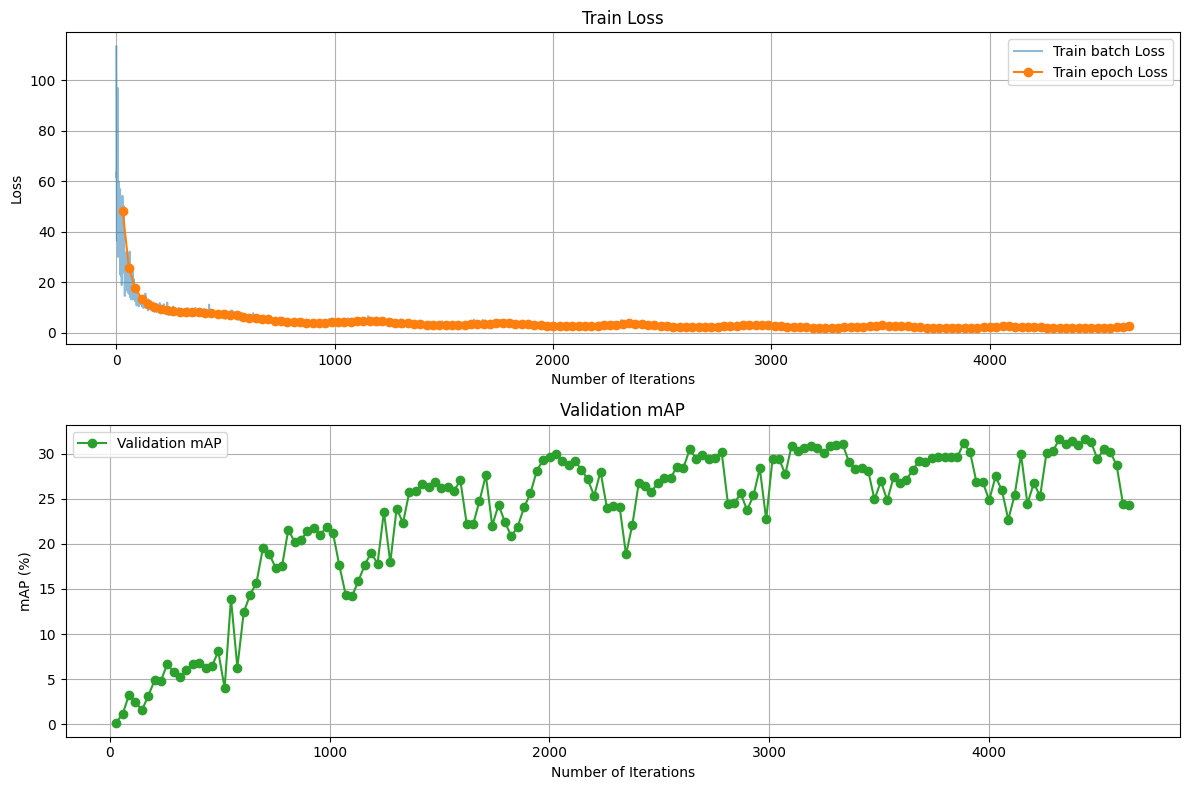

In [77]:
runner.plot_loss(row_figsize=4)

In [76]:
model.load_state_dict(torch.load('/kaggle/working/detector_sd', weights_only=True))

<All keys matched successfully>

In [78]:
final_map = runner.validate(dataloader=val_loader)
print(f"Final Test mAP: {final_map:.4f}")

Running validation:   0%|          | 0/5 [00:00<?, ?it/s]

Final Test mAP: 0.3163


Image 1: Found 6 predictions after filtering (score > 0.15).
Image 2: Found 0 predictions after filtering (score > 0.15).
Image 3: Found 0 predictions after filtering (score > 0.15).
Image 4: Found 2 predictions after filtering (score > 0.15).
Image 5: Found 2 predictions after filtering (score > 0.15).


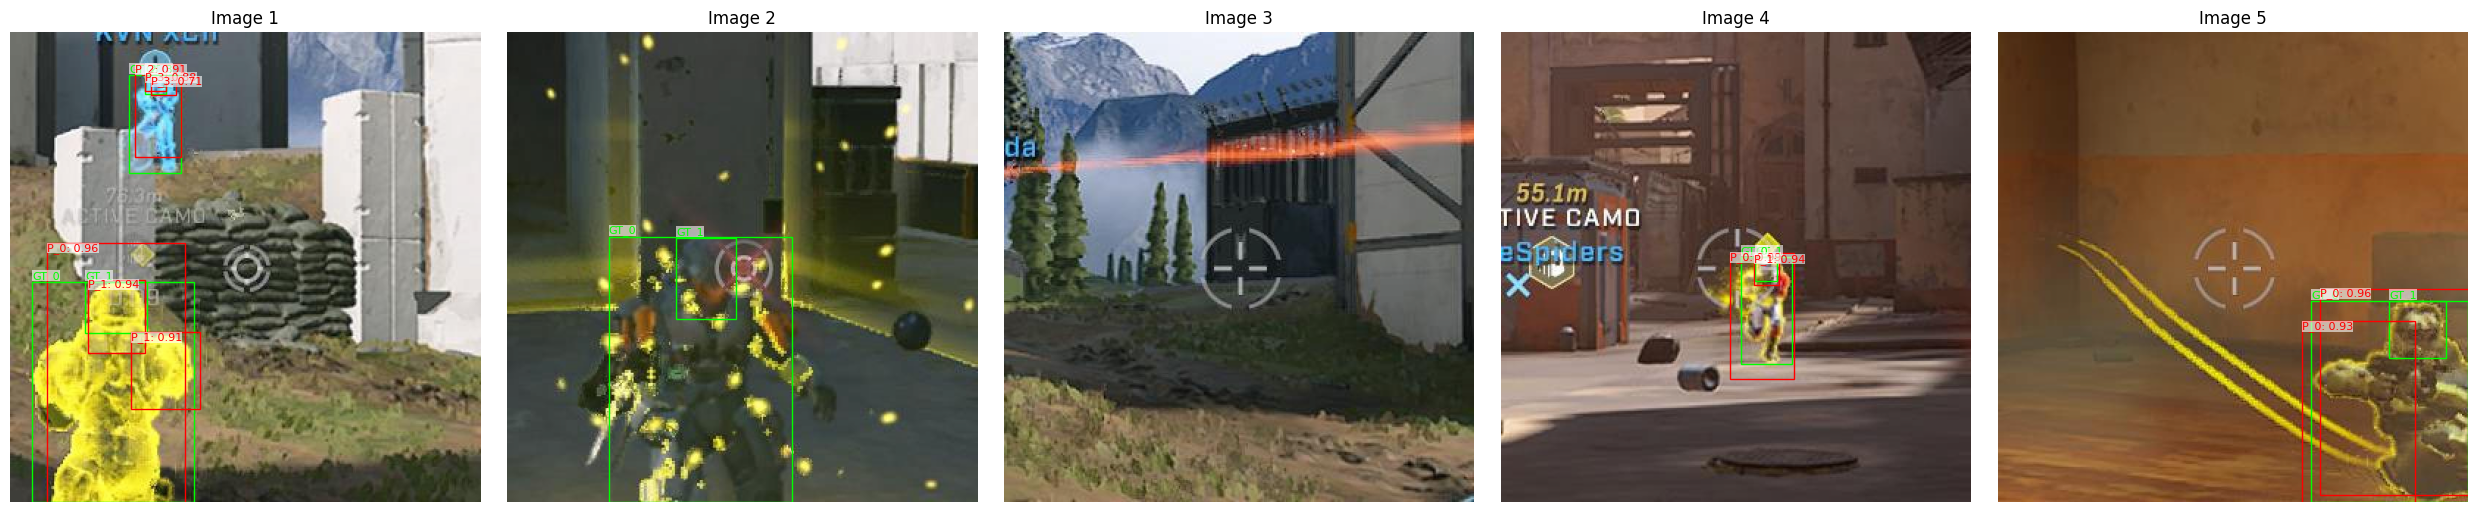

In [83]:
import matplotlib.patches as patches
import random

def visualize_predictions_inline(model, dataloader, device, num_images=5, score_threshold=0.1, nms_threshold=0.5, filter_func=None, fig_width_per_image=4, fig_height=4):
    model.eval()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    filter_predictions_func = _filter_predictions
    data_iter = iter(dataloader)
    images_shown = 0

    fig, axes = plt.subplots(1, num_images, figsize=(num_images * fig_width_per_image, fig_height))
    if num_images == 1:
        axes = [axes]

    while images_shown < num_images:
        images, targets = next(data_iter)
        for i in range(len(images)):
            if images_shown >= num_images:
                break

            image_single = images[i:i+1].to(device)
            target_single = [targets[i]] 

            with torch.no_grad():
                (cls_preds_levels, reg_preds_levels, obj_preds_levels), anchors_levels_xyxy = model(image_single)
                pred_bboxes_batch, pred_obj_scores_batch, pred_cls_scores_batch = runner._decode_predictions(
                    [lvl[0:1] for lvl in reg_preds_levels],
                    [lvl[0:1] for lvl in obj_preds_levels],
                    [lvl[0:1] for lvl in cls_preds_levels],
                    anchors_levels_xyxy
                )
                final_preds = filter_predictions_func(
                    pred_bboxes_batch, pred_obj_scores_batch, pred_cls_scores_batch,
                    num_classes=model.num_classes,
                    score_threshold=score_threshold,
                    nms_threshold=nms_threshold,
                    max_boxes_per_cls=100,
                    return_type="torch"
                )

            img_tensor = image_single[0].cpu()
            pred_data = final_preds[0]
            gt_data = target_single[0]

            img_np = img_tensor.permute(1, 2, 0).numpy()
            img_np = np.clip((img_np * std + mean), 0, 1)

            ax = axes[images_shown]
            ax.imshow(img_np)
            ax.set_title(f"Image {images_shown+1}")
            ax.axis('off')

            gt_boxes = gt_data['boxes']
            gt_labels = gt_data['labels']
            for box, label in zip(gt_boxes, gt_labels):
                box_cpu = box.cpu().tolist()
                label_cpu = label.cpu().item()
                x1, y1, x2, y2 = box_cpu
                rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='lime', facecolor='none') # Зеленый для GT
                ax.add_patch(rect)
                ax.text(x1, y1 - 5, f'GT_{label_cpu}', color='lime', fontsize=8, bbox=dict(facecolor='white', alpha=0.6, pad=0, edgecolor='none'))

            boxes = pred_data['boxes'].cpu()
            labels = pred_data['labels'].cpu()
            scores = pred_data['scores'].cpu()

            print(f"Image {images_shown+1}: Found {len(boxes)} predictions after filtering (score > {score_threshold}).")

            for box, label, score in zip(boxes, labels, scores):
                x1, y1, x2, y2 = box.tolist()
                rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='red', facecolor='none') # Красный для предсказаний
                ax.add_patch(rect)
                ax.text(x1, y1 + 10, f'P_{label.item()}: {score:.2f}', color='red', fontsize=8, bbox=dict(facecolor='white', alpha=0.6, pad=0, edgecolor='none'))

            images_shown += 1

    plt.tight_layout()
    plt.show()

visualize_predictions_inline(
    runner.model,
    test_loader,
    runner.device,
    num_images=5,
    score_threshold=0.15,
    nms_threshold=0.4,
    fig_width_per_image=5,
    fig_height=5
)